## Goal
As a first pass at developing a machine learning model to predict California wildfires I will evaluate and tune several different gradient boosting algorithms. The procedure will be as follows:

1. **Classifier selection:** Find the best classification algorithm for the data based on F1 score compute time and memory requirements
2. **Class imbalance:** Generate a strategy to deal with the unbalanced nature of the classes
2. **Metaparameter optimization:** Optimize data metaparameters such as rolling window width
3. **Hyperparameter optimization:** Tune model hyperparameters
4. **Feature importance:** Investigate feature importance and possibly trim/apply dimensionality reduction techniques to the data

There are two anticipated issues which will need to be dealt with first:

1. Large dataset size - current working dataset has 7.3 million observations of 25 variables and this is likely to grow as the project progresses
2. Highly imbalanced data (~20 times more observations without fire than with)

Future goals are to add several more factors from various data sources including: elevation, population density, time since last fire and total fires.

**Imports and notebook setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from random import randint
from time import time
from statistics import mean
from scipy import stats
from memory_profiler import memory_usage
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

from sklearn.utils.fixes import loguniform
from IPython.display import display_markdown
from scipy.interpolate import griddata

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()

<Figure size 432x288 with 0 Axes>

**Variable definitions**

In [2]:
raw_data_file = '../data/training_data/1992-1997_training_data_raw.csv'
rolling_window_data_file = '../data/training_data/1992-1997_training_data_rolling_window.csv'
daily_mean_data_file = '../data/training_data/1992-1997_training_data_daily_mean.csv'
rand_seed = 123

data_sample_size = int(7300000 * 0.01)

test_train_split_ratio = 0.3
classifier_jobs = 15
optimization_jobs = 1
max_jobs = classifier_jobs * optimization_jobs
num_trials = 3
search_iterations = 500
search_scoring_func = make_scorer(average_precision_score)
plot_grid_resolution = 500
contourf_levels = 500

**Functions**

In [3]:
def k_random_sample(data, k):
    n = len(data)
    indices = random.sample(range(0, n), k)
    return data.iloc[indices]

def stratified_train_test_split(data, targets, rand_seed):
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_train_split_ratio, 
        random_state=rand_seed
    )

    for train_index, test_index in sss.split(data, targets):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

def sample_data(data, data_sample_size):

    # split positive and negative datsets up
    ignitions = data[data['ignition'] > 0]
    no_ignitions = data[data['ignition'] == 0]
    
    # due to the moving average we will have some positive observations with
    # fractional ignition values
    ignitions = ignitions.assign(ignition=1)
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, data_sample_size)
    ignitions_sample = k_random_sample(ignitions, data_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data
    
def calc_false_neg_pos_rate(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))

    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]

    false_neg_rate = FN / (FN + TN)
    false_pos_rate = FP / (FP + TN)
    
    return false_neg_rate, false_pos_rate

def train_model(classifier, x_train, y_train):
    model = classifier
    model.fit(x_train, y_train)
    return model
    

def compare_algorithms(
    classifiers, 
    model_descriptions,
    num_trials,
    data_moving_avg,
    data_sample_size
):
    
    # Set up empty dataframe to hold resutlts
    model_scores_columns = [
        'Classifier',
        'n trials',
        'Sample size',
        'Time (min.)',
        'Peak memory (GB)',
        'Training score +/- SD',
        'Test score +/- SD',
        'False positive rate +/- SD',
        'False negative rate +/- SD'
    ]
    
    model_scores = pd.DataFrame(columns=model_scores_columns)    
    
    # Loop over the diffrent classifiers
    for classifier, description in zip(classifiers, model_descriptions):
        train_scores = []
        test_scores = []
        false_pos_rates = []
        false_neg_rates = []
        mem_usages = []
        
        start = time()
        
        for i in range(num_trials):
            # Resample and train-test split data
            sampled_data = sample_data(data_moving_avg, data_sample_size)
            targets = sampled_data['ignition']
            data = sampled_data.drop(['ignition'], axis=1)
            x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)
        
            # Initalize and train model on sampled data
            mem_usage, model = memory_usage((train_model, (classifier, x_train, y_train)), retval=True)
            max_mem = max(mem_usage)
            mem_usages.append(max_mem)

            train_scores.append(average_precision_score(model.predict(x_train), y_train))
            test_scores.append(average_precision_score(model.predict(x_test), y_test))
            false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(model, x_test, y_test)
            false_neg_rates.append(false_neg_rate)
            false_pos_rates.append(false_pos_rate)
            
        stop = time()
        dT = np.round(((stop - start)/60), 2)
        
        peak_memory = np.round((max(mem_usages)/1000), 5)
        
        avg_train_score = mean(train_scores)
        avg_test_score = mean(test_scores)
        avg_false_neg_rate = mean(false_neg_rates)
        avg_false_pos_rate = mean(false_pos_rates)
        
        std_train_score = np.std(train_scores)
        std_test_score = np.std(test_scores)
        std_false_neg_rate = np.std(false_neg_rates)
        std_false_pos_rate = np.std(false_pos_rates)
        
        print('{} trials with {} took {} min. on {} observations'.format(
            num_trials, 
            description, 
            dT,
            data_sample_size
        ))
        
        model_scores = model_scores.append(pd.Series([
            description,
            num_trials,
            data_sample_size,
            dT,
            peak_memory,
            '{:.2f} +/- {:.3f}'.format(np.round(avg_train_score,2), np.round(std_train_score,3)),
            '{:.2f} +/- {:.3f}'.format(np.round(avg_test_score,2), np.round(std_test_score,3)),
            '{:.2f} +/- {:.3f}'.format(np.round(avg_false_pos_rate,2), np.round(std_false_pos_rate,3)),
            '{:.2f} +/- {:.3f}'.format(np.round(avg_false_neg_rate,2), np.round(std_false_neg_rate,3)),
        ], index=model_scores.columns), ignore_index=True)
        
        i += 1
        
    return model_scores
    
def test_scoring_functions(
    num_trials,
    scoring_functions, 
    data_moving_avg,
    data_sample_size,
    max_jobs
):
    
    # Set up empty dataframe to hold resutlts
    model_scores_columns = [
        'Scoring function',
        'n',
        'Training score +/- STD',
        'Test score +/- STD',
        'False positive rate +/- STD',
        'False negative rate +/- STD'
    ]
    
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for scoring_function in scoring_functions:
        train_scores = []
        test_scores = []
        false_pos_rates = []
        false_neg_rates = []
        
        for i in range(num_trials):
            # Resample and train-test split data
            sampled_data = sample_data(data_moving_avg, data_sample_size)
            targets = sampled_data['ignition']
            data = sampled_data.drop(['ignition'], axis=1)
            x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)
            
            catboost_mod = CatBoostClassifier(
                thread_count = max_jobs,
                score_function = scoring_function
            )

            catboost_mod.fit(x_train, y_train, silent=True)

            train_scores.append(average_precision_score(catboost_mod.predict(x_train), y_train))
            test_scores.append(average_precision_score(catboost_mod.predict(x_test), y_test))
            false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_mod, x_test, y_test)
            false_neg_rates.append(false_neg_rate)
            false_pos_rates.append(false_pos_rate)
            
        avg_train_score = mean(train_scores)
        avg_test_score = mean(test_scores)
        avg_false_neg_rate = mean(false_neg_rates)
        avg_false_pos_rate = mean(false_pos_rates)
        
        std_train_score = np.std(train_scores)
        std_test_score = np.std(test_scores)
        std_false_neg_rate = np.std(false_neg_rates)
        std_false_pos_rate = np.std(false_pos_rates)
        
        model_scores = model_scores.append(pd.Series([
            scoring_function,
            num_trials,
            '{} +/- {}'.format(np.round(avg_train_score,2), np.round(std_train_score,3)),
            '{} +/- {}'.format(np.round(avg_test_score,2), np.round(std_test_score,3)),
            '{} +/- {}'.format(np.round(avg_false_pos_rate,2), np.round(std_false_pos_rate,3)),
            '{} +/- {}'.format(np.round(avg_false_neg_rate,2), np.round(std_false_neg_rate,3)),
        ], index=model_scores.columns), ignore_index=True)
        
        i += 1

    return model_scores

def plot_relative_feature_importance(model, data, x_test, x_tick_size):
    importances = catboost_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = np.array(list(data))

    plt.figure(figsize=(20,10))
    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=x_tick_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
    plt.title("Feature importance")
    plt.bar(range(x_test.shape[1]), importances[indices],
           color="darkblue", align="center")
    plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
    plt.xlim([-1, x_test.shape[1]])
    plt.xlabel("Feature")
    plt.ylabel("Relative importance")
    
    plt.show()
    
def tune_class_weight(
    class_weights, 
    x_train, 
    y_train, 
    x_test, 
    y_test
):
    model_scores_columns = [
        'Class weight',
        'Training score',
        'Test score',
        'False positive rate',
        'False negative rate'
    ]
    
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for class_weight in class_weights:
        model = XGBClassifier()
        model.fit(x_train, y_train)

        training_score = average_precision_score(model.predict(x_train), y_train)
        test_score = average_precision_score(model.predict(x_test), y_test)
        false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(model, x_test, y_test)
        model_scores = model_scores.append(pd.Series([class_weight, np.round(training_score,2), np.round(test_score,2), np.round(false_pos_rate,2), np.round(false_neg_rate,2)], index=model_scores.columns), ignore_index=True)

    return model_scores

def plot_class_weight_tuning_results(model_scores):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    plt.subplots(1,2,figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    
    plt.scatter(
        np.log10(model_scores['Class weight']), 
        model_scores['False positive rate'], 
        s=20, 
        c='darkblue', 
        label='False positive'
    )
    
    plt.scatter(
        np.log10(model_scores['Class weight']), 
        model_scores['False negative rate'], 
        s=20, 
        c='darkred', 
        label='False negative'
    )
    
    plt.legend(loc='upper left')
    plt.xlabel("Log 10 class weight")
    plt.ylabel("Rate")
    plt.title("Class weight and false prediction rates")

    plt.subplot(1, 2, 2)
    
    plt.scatter(
        np.log10(model_scores['Class weight']), 
        model_scores['Training score'], 
        s=20, 
        c='darkblue', 
        label='Training'
    )
    
    plt.scatter(
        np.log10(model_scores['Class weight']),
        model_scores['Test score'],
        s=20, 
        c='darkred', 
        label='Test'
    )
    
    plt.legend(loc='lower right');
    plt.xlabel("Log 10 class weight")
    plt.ylabel("Score")
    plt.title("Class weight and precision-recall score")

    plt.tight_layout()
    plt.show()
    

def train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
):
    
    # Set up empty dataframe to hold resutlts
    model_scores_columns = [
        'Scoring function',
        'n',
        'Training score +/- STD',
        'Test score +/- STD',
        'False positive rate +/- STD',
        'False negative rate +/- STD'
    ]
    
    model_scores = pd.DataFrame(columns=model_scores_columns)

    train_scores = []
    test_scores = []
    false_pos_rates = []
    false_neg_rates = []
        
    for i in range(num_trials):
        # Resample and train-test split data
        sampled_data = sample_data(data_moving_avg, data_sample_size)
        targets = sampled_data['ignition']
        data = sampled_data.drop(['ignition'], axis=1)
        x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values)

        catboost_mod = CatBoostClassifier(**known_params)
        catboost_mod.fit(x_train, y_train, silent=True)

        train_scores.append(average_precision_score(catboost_mod.predict(x_train), y_train))
        test_scores.append(average_precision_score(catboost_mod.predict(x_test), y_test))
        false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_mod, x_test, y_test)
        false_neg_rates.append(false_neg_rate)
        false_pos_rates.append(false_pos_rate)
        
        i += 1
            
    avg_train_score = mean(train_scores)
    avg_test_score = mean(test_scores)
    avg_false_neg_rate = mean(false_neg_rates)
    avg_false_pos_rate = mean(false_pos_rates)

    sem_train_score = stats.sem(train_scores)
    sem_test_score = stats.sem(test_scores)
    sem_false_neg_rate = stats.sem(false_neg_rates)
    sem_false_pos_rate = stats.sem(false_pos_rates)

    model_scores = model_scores.append(pd.Series([
        'Catboost with scoring function & class weight',
        num_trials,
        '{} +/- {}'.format(np.round(avg_train_score,2), np.round(sem_train_score,3)),
        '{} +/- {}'.format(np.round(avg_test_score,2), np.round(sem_test_score,3)),
        '{} +/- {}'.format(np.round(avg_false_pos_rate,2), np.round(sem_false_pos_rate,3)),
        '{} +/- {}'.format(np.round(avg_false_neg_rate,2), np.round(sem_false_neg_rate,3)),
    ], index=model_scores.columns), ignore_index=True)

    return model_scores

def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize catboost classifier
    model = CatBoostClassifier(**known_params)

    # set up random search
    random_search = RandomizedSearchCV(
        model, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    best_model = random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return best_model, random_search

def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

## Data preparation

In [4]:
# File paths
raw_data_file = '../data/training_data/1992-1997_training_data_raw.csv'
rolling_window_data_file = '../data/training_data/1992-1997_training_data_rolling_window.csv'
daily_mean_data_file = '../data/training_data/1992-1997_training_data_daily_mean.csv'

In [5]:
# Load data
raw_data = pd.read_csv(raw_data_file, low_memory=False)
data_rolling_window = pd.read_csv(rolling_window_data_file, low_memory=False)
data_daily_mean = pd.read_csv(daily_mean_data_file, low_memory=False)

In [ ]:
# Drop unnecessary time variables
raw_data.drop(['weather_bin_time', 'weather_bin_day'], axis=1, inplace=True)
data_rolling_window.drop(['weather_bin_time', 'weather_bin_day'], axis=1, inplace=True)
data_daily_mean.drop(['weather_bin_day'], axis=1, inplace=True)

In [6]:
# Shuffel row order
raw_data = raw_data.sample(frac=1).reset_index(drop=True)
data_rolling_window = data_rolling_window.sample(frac=1).reset_index(drop=True)
data_daily_mean = data_daily_mean.sample(frac=1).reset_index(drop=True)

## Baseline: default and oracle models

Goal here is to establish upper and lower bounds on what is possible with our dataset. We will do this by creating two models:

1. Oracle model - best possible performance, train directly on the test set with no regularization
2. Dummy model - predict major class for all test set observations

These two models will give us a context in which to evaluate how well we are doing. At the same time we will also evaluate three different versions of our dataset.

1. Raw data
2. Data averaged with a 24 hr rolling mean
3. Data averaged by day

In [7]:
datasets = (raw_data, data_rolling_window, data_daily_mean)

In [8]:
# Dummy model, pretend we are doing it for real
dummy_scores = []

for dataset in datasets:
    # Seprate data and labels
    y = dataset['ignition']
    X = dataset.drop('ignition', axis=1)
    
    # Stratified test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split_ratio, random_state=rand_seed, stratify=y)    
    
    # train and score dummy model
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    f1 = np.round(f1_score(y_test, y_pred),3)

    dummy_scores.append(f1)
    
print(dummy_scores)

[0.0, 0.0, 0.0]


As expected, calling no fire all the time results in an f1 score of zero for all test sets.

In [9]:
# Oracle, if we allow overfitting how well can we do?
oracle_scores = []

for dataset in datasets:
    # Seprate data and labes
    y = dataset['ignition']
    X = dataset.drop('ignition', axis=1)
    
    # Stratified test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split_ratio, random_state=rand_seed, stratify=y)    
    
    # train and score dummy model
    oracle_clf = RandomForestClassifier(n_jobs=max_jobs, random_state=rand_seed)
    oracle_clf.fit(X_test, y_test)
    y_pred = oracle_clf.predict(X_test)
    f1 = np.round(f1_score(y_test, y_pred),3)
    oracle_scores.append(f1)
    
print(oracle_scores)

[1.0, 1.0, 1.0]


Also as expected, purposefully overfitting on the test set results in a test f1 score of 1.0. Therefore, there is enough information in the data to predict ignitions if we exclude any consideration of generalizability.

## Classifier selection: kitchen sink approach

First step is to throw a bunch of different classifiers with default settings at the problem and see how they do. See list below for contenders.

We will start with a small sample of daily average data to quickly get a sense of how well each classifier works. Hopefully we can discard some to make test run times shorter in the next round.

In [325]:
# SKLearn classifiers
classifier_descriptions = [
    'Logit. regres.',
    'Decision tree',
    'K neighbors',
    'Rand. forest',
    'QDA',
    'XGBoost',
    'CatBoost',
    'LightGBM',
    'AdaBoost',
    'Linear SVM',
    'RBF SVM',
    'Naive Bayes',
    'Gaussian proc.'
]

# Classifiers with parameters. Set parallism and rand_seed if avalible.
# Also set 'rule of thumb' class weight if avalible for that classifier.

num_negative_observations = len(data_daily_mean[data_daily_mean['ignition'] == 0])
num_positive_observations = len(data_daily_mean[data_daily_mean['ignition'] == 1])
class_ratio = num_negative_observations / num_positive_observations

class_weight_dict = {
    0: (1 / class_ratio),
    1: 1 - (1 / class_ratio)
}

classifiers = (
    
    LogisticRegression(
        n_jobs = max_jobs, 
        random_state = rand_seed,
        class_weight = class_weight_dict
    ),
    
    DecisionTreeClassifier( 
        random_state = rand_seed,
        class_weight = class_weight_dict
    ),
    
    KNeighborsClassifier(
        n_jobs = max_jobs        
    ),
    
    RandomForestClassifier(
        n_jobs = max_jobs,
        class_weight = class_weight_dict,
        random_state = rand_seed
    ),
    
    QuadraticDiscriminantAnalysis(),
    
    XGBClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    CatBoostClassifier(
        thread_count = max_jobs, 
        silent = True,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    LGBMClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
     AdaBoostClassifier(random_state = rand_seed),
    
    SVC(kernel = "linear",
        class_weight = 'balanced',
        random_state = rand_seed
    ),
    
    SVC(
        class_weight = 'balanced',
        random_state = rand_seed
    ),
    
    GaussianNB(),
    
    GaussianProcessClassifier(
        n_jobs = max_jobs,
        random_state = rand_seed
    )
)

In [326]:
# Functions

def k_random_sample(data, k):
    n = len(data)
    indices = random.sample(range(0, n), k)
    return data.iloc[indices]

def stratified_sample(data, n):
    # split positive and negative datsets up
    ignitions = data[data['ignition'] == 1]
    no_ignitions = data[data['ignition'] == 0]
    
    # Calculate ignition & no ignition sample sizes
    ignition_fraction = len(ignitions) / len(data)
    ignition_sample_size = int((n * ignition_fraction))
    no_ignition_sample_size = int((n * (1 - ignition_fraction)))
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
    ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data

def cross_validate_classifier(classifier, X_train, y_train, folds, scoring_func):
    model = classifier
    cv = StratifiedKFold(n_splits=folds)
    cross_val_scores = cross_val_score(model, X_train, y_train, scoring=scoring_func, cv=cv)
    return cross_val_scores

In [304]:
# Variables
cv_folds = 5
sample_size = 10000
scoring_func = make_scorer(f1_score)

In [305]:
# Take stratified sample of daily mean data and do stratified test-train split    
sampled_data = stratified_sample(data_daily_mean, sample_size)

y = sampled_data['ignition']
X = sampled_data.drop('ignition', axis=1)
    
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=test_train_split_ratio, 
    random_state=rand_seed, 
    stratify=y
)

from sklearn.preprocessing import StandardScaler

# Scale weather variables, leave out lat, lon and date/time
columns_to_scale = X_train.columns[4:]

scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])

X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [306]:
# Loop over classifier list, run k-fold cross validation on stratified training sample
# for each. Report mean and SD of score, run time and peak memory use
raw_scores = []
score_means = []
score_sds = []
mem_usages = []
run_times = []

# Start empty dataframe to hold results
classifier_data = pd.DataFrame(columns=[
    'Classifier',
    'Sample size',
    'CV folds',
    'Raw scores',
    'Mean F1 score',
    'F1 score SD',
    'Peak memory (GB)',
    'Run time (min.)'
])

for classifier, description in zip(classifiers, classifier_descriptions):
    
    start = time()
    
    mem_usage, cross_val_scores = memory_usage((cross_validate_classifier, (
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func)
    ), retval=True)
    
    dT = np.round(((time() - start)/60),2)
    
    raw_scores.append(cross_val_scores)
     
    mean_score = np.round(mean(cross_val_scores),3)
    sd_score = np.round(np.std(cross_val_scores),4)
    max_mem = np.round((max(mem_usage) / 1000),3)
    
    mem_usages.append(max_mem)
    run_times.append(dT)
    score_means.append(mean_score)
    score_sds.append(sd_score)
    
    classifier_data = classifier_data.append(pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        max_mem,
        dT
    ], index=classifier_data.columns), ignore_index=True)
    
classifier_data = classifier_data.sort_values(['Mean F1 score'], ascending=[0])

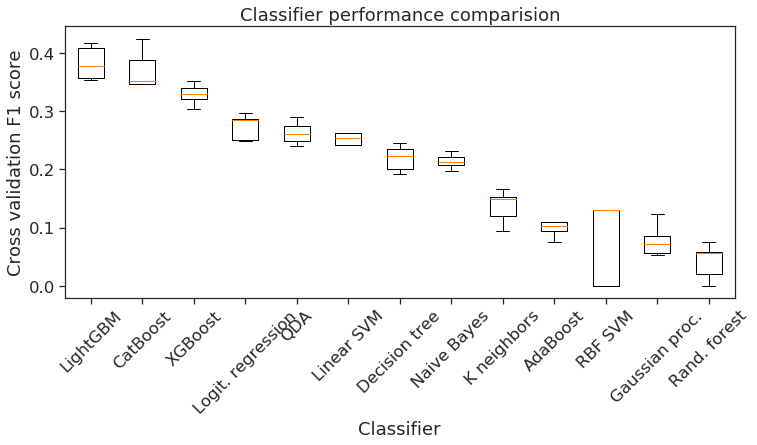

In [337]:
fig = plt.figure(1, figsize=(12, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data['Raw scores'])
ax.set_xticklabels(classifier_data['Classifier'])
plt.xlabel('Classifier')
plt.ylabel('Cross validation F1 score')
plt.title('Classifier performance comparision')
plt.xticks(rotation=45)
plt.show()

In [307]:
classifier_data

,Classifier,Sample size,CV folds,Raw scores,Mean F1 score,F1 score SD,Peak memory (GB),Run time (min.)
7,LightGBM,10000,5,"[0.41777777777777775, 0.4090909090909091, 0.35...",0.383,0.0261,4.677,0.03
6,CatBoost,10000,5,"[0.3876651982378855, 0.35238095238095235, 0.34...",0.372,0.0305,4.677,0.44
5,XGBoost,10000,5,"[0.33035714285714285, 0.32119914346895073, 0.3...",0.329,0.0165,4.675,0.02
0,Logit. regression,10000,5,"[0.24954128440366968, 0.2851919561243144, 0.25...",0.274,0.0196,4.675,0.04
4,QDA,10000,5,"[0.2481751824817518, 0.2753872633390706, 0.240...",0.263,0.0179,4.675,0.01
9,Linear SVM,10000,5,"[0.24179104477611943, 0.25411061285500747, 0.2...",0.253,0.0090,4.677,0.09
1,Decision tree,10000,5,"[0.20100502512562812, 0.1925133689839572, 0.22...",0.219,0.0198,4.675,0.01
11,Naive Bayes,10000,5,"[0.19714964370546317, 0.2222222222222222, 0.20...",0.214,0.0120,4.671,0.00
2,K neighbors,10000,5,"[0.16666666666666666, 0.11965811965811965, 0.0...",0.136,0.0262,4.675,0.02
8,AdaBoost,10000,5,"[0.11009174311926606, 0.09345794392523366, 0.1...",0.098,0.0129,4.677,0.07


Not surprisingly, our top three winners are gradient boosting algorithms. All three are within a standard deviation of each other, but CatBoost takes ~15 times longer than the other two. Let's focus on the top three and quickly check how well they will scale as the dataset grows.

## Classifier selection: resource requirements

In [308]:
classifier_descriptions = [
    'LightGBM',
    'CatBoost',
    'XGBoost'
]

classifiers = (
    
    LGBMClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    CatBoostClassifier(
        thread_count = max_jobs, 
        silent = True,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    XGBClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
)

In [315]:
sample_size = 3000
n_doublings = 5

sample_size_data = pd.DataFrame(columns=[
    'Classifier',
    'Sample size',
    'Peak memory (GB)',
    'Run time (min.)'
])

def fit_model(classifier, X, y):
    model = classifier
    model.fit(X, y)
    return model

for i in range(0,(n_doublings+1)):
    sampled_data = stratified_sample(data_daily_mean, sample_size)
    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)
    
    for classifier, description in zip(classifiers, classifier_descriptions):
        start = time()
        mem_usage, model = memory_usage((fit_model, (classifier, X, y)), retval=True)
        dT = np.round(((time() - start)/60),2)
        
        max_mem = np.round((max(mem_usage) / 1000),3)
        
        sample_size_data = sample_size_data.append(pd.Series([
            description,
            sample_size,
            max_mem,
            dT
        ], index=sample_size_data.columns), ignore_index=True)
    
    sample_size = sample_size * 2

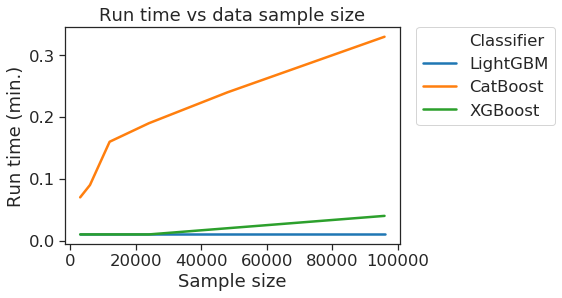

In [316]:
ax = sns.lineplot(x='Sample size', y='Run time (min.)', hue='Classifier', data=sample_size_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Run time vs data sample size')
plt.show()

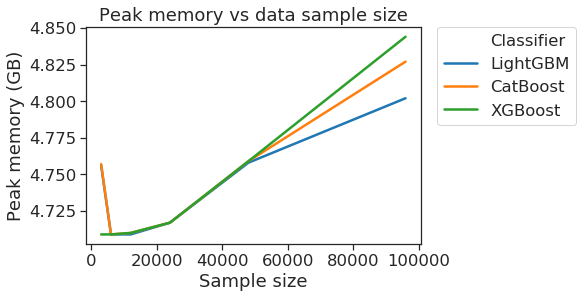

In [317]:
ax = sns.lineplot(x='Sample size', y='Peak memory (GB)', hue='Classifier', data=sample_size_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Peak memory vs data sample size')
plt.show()

Looks like XGBoost is the holistic winner. XGBoost's cross validation f1 score is within a standard deviation of CatBoost and it seems to be significantly faster. It does appear to use slightly more memory, hopefully that won't be a problem. Let's look at it in a bit more detail:

Raw count confusion matrix
[[2145  646]
 [  38  171]]


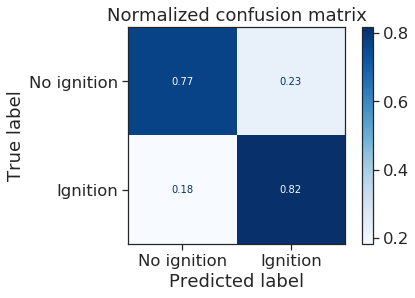

In [318]:
def display_confusion_matrix(model, class_names, x_test, y_test):

    raw_cm = confusion_matrix(y_test, model.predict(x_test))
    print("Raw count confusion matrix")
    print(raw_cm)
    
    normalized_cm = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    normalized_cm.ax_.set_title("Normalized confusion matrix")

    plt.show()

model = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

model.fit(X_train, y_train)

class_names = np.array(['No ignition', 'Ignition'])
display_confusion_matrix(model, class_names, X_test, y_test)

In [327]:
def calc_false_neg_pos_rate(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))

    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]

    false_neg_rate = FN / (FN + TN)
    false_pos_rate = FP / (FP + TN)
    
    return false_neg_rate, false_pos_rate

false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(model, X_test, y_test)
print("False negative rate: {}".format(np.round(false_neg_rate, 2)))
print("False positive rate: {}".format(np.round(false_pos_rate, 2)))

False negative rate: 0.02
False positive rate: 0.24


Given the nature of the problem, false negative are more dangerous than false positives. So we are in the right regime. Hopefully we can bring the false positive rate down a bit. Crying wolf one in four times is not ideal.

## Metaparameter optimization: to smooth or not to smooth

You may have notices that I loaded three different datasets at the start of this notebook:

1. **raw_data:** No significant manipulations beyond collating the various datasets. Has a time resolution of 3 hr. due to the frequency of the original NOAA weather data set.
2. **data_rolling_window:** Data was reversed with regard to time and then averaged with a 6 hr. rolling window. This has the effect of assigning the window mean to the time bin at the left of the window. This was done because logically we should care more about weather conditions before the fire was discovered than after.
3. **data_daily_mean:** Rolling window data was averaged by day.

**Note:** All averaging includes the boolean ignition value. After averaging is complete any noxel with a non-zero ignition value is reassigned a 1. This tends to make the fires discovery 'spread' to earlier times. Again, this is acceptable and even desirable because logically the fire must have started before it was discovered.

OK, so, let's compare the three sets with cross validation.

In [332]:
# Loop over dataset list, run k-fold cross validation on stratified training sample
# for each. Report raw scores.

dataset_descriptions = [
    "Raw data",
    "Rolling window",
    "Daily average"
]

datasets = (
    raw_data,
    data_rolling_window,
    data_daily_mean
)

classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

# Start empty dataframe to hold results
dataset_comparison_results = pd.DataFrame(columns=[
    'Data type',
    'Raw scores',
])

for dataset, description in zip(datasets, dataset_descriptions):
    
    # Take stratified sample of daily mean data and do stratified test-train split    
    sampled_data = stratified_sample(dataset, sample_size)

    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=test_train_split_ratio, 
        random_state=rand_seed, 
        stratify=y
    )

    # Scale weather variables, leave out lat, lon and date/time
    columns_to_scale = X_train.columns[4:]

    scaler = StandardScaler()
    scaler.fit(X_train[columns_to_scale])

    X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    cross_val_scores = cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func
    )
    
    dataset_comparison_results = dataset_comparison_results.append(pd.Series([
        description,
        cross_val_scores,
    ], index=dataset_comparison_results.columns), ignore_index=True)
    
dataset_comparison_results

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Data type,Raw scores
0,Raw data,"[0.25671641791044775, 0.29651162790697677, 0.2..."
1,Rolling window,"[0.31578947368421056, 0.296137339055794, 0.327..."
2,Daily average,"[0.30679611650485433, 0.2923976608187135, 0.30..."


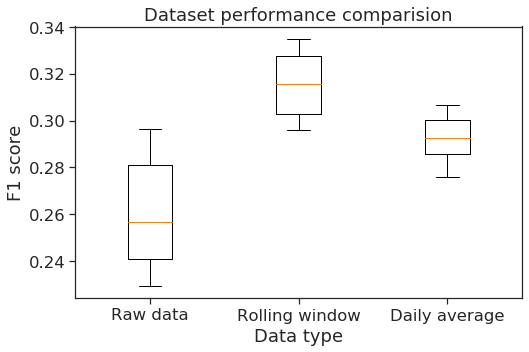

In [336]:
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(dataset_comparison_results['Raw scores'])
ax.set_xticklabels(dataset_comparison_results['Data type'])
plt.xlabel('Dataset')
plt.ylabel('Cross validation F1 score')
plt.title('Dataset performance comparision')
#plt.xticks(rotation=45)
plt.show()

Ok, looks like the rolling window is the winner, though the daily average is close. We should keep this in mind because running a daily average reduces the total size of the dataset by 8 fold. If we run into resource trouble the ability to use 8x as much data might out weight the decrease in score caused by averaging.

## Metaparameter optimization: rolling window width

The use of a rolling window introduces a possibly extremely important metaparameter: the rolling window width. Let's play with that next.

In [341]:
raw_data.head()

,lat,lon,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,uwnd.10m,...,lcdc,hcdc,mcdc,hpbl,prate,vis,ulwrf.sfc,ignition,weather_bin_month,weather_bin_year
0,33.07055,-116.2315,302.16870,304.08460,0.000000,0.0,28.518984,283.64038,95430.836,2.696884,...,0.0,3.0,0.0,1536.95630,0.000000e+00,20006.9510,462.6875,0.0,9,1996
1,37.12544,-122.3103,296.11078,288.63092,0.000000,0.0,63.207523,281.60400,99312.375,5.548218,...,14.0,20.0,0.0,734.46265,0.000000e+00,16408.4800,424.9375,0.0,3,1997
2,36.18763,-116.3589,275.44214,276.92404,0.000000,0.0,79.630516,273.69955,90336.870,1.403366,...,0.0,0.0,0.0,415.39874,-3.792363e-06,20005.9980,357.8750,0.0,11,1997
3,38.80434,-122.7591,275.15808,276.05580,1.015625,0.0,83.818980,273.54617,94225.390,5.129288,...,96.0,0.0,86.0,1099.65000,1.182779e-04,2409.6465,324.5625,0.0,3,1995
4,37.16882,-120.1348,283.72913,285.60898,0.000000,0.0,75.523610,281.34094,100314.280,2.718430,...,0.0,100.0,28.0,409.80487,-4.901570e-07,20008.2000,359.4375,0.0,3,1994


In [352]:
# Loop over rolling window sizes, run k-fold cross validation on stratified training sample
# for each. Report raw scores.

window_widths = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 26, 28, 30, 32, 34]

# Reload our raw data
raw_data = pd.read_csv(raw_data_file, low_memory=False)

classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

# Start empty dataframe to hold results
rolling_window_comparison_results = pd.DataFrame(columns=[
    'Window width (hr.)',
    'Raw scores',
])

for window_width in window_widths:
    
    # Reverse and roll data with window width
    data_rolling_window = raw_data.iloc[::-1]
    data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(window_width, on="weather_bin_time").mean()
    data_rolling_window.reset_index(drop=True, inplace=True)
    
    ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
    no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
    ignitions['ignition'] = 1

    data_rolling_window = ignitions.append(no_ignitions)
    
    data_rolling_window.drop(['weather_bin_time', 'weather_bin_day'], axis=1, inplace=True)
    
    # Take stratified sample of daily mean data and do stratified test-train split    
    sampled_data = stratified_sample(data_rolling_window, sample_size)

    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=test_train_split_ratio, 
        random_state=rand_seed, 
        stratify=y
    )

    # Scale weather variables, leave out lat, lon and date/time
    columns_to_scale = X_train.columns[4:]

    scaler = StandardScaler()
    scaler.fit(X_train[columns_to_scale])

    X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    cross_val_scores = cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func
    )
    
    rolling_window_comparison_results = rolling_window_comparison_results.append(pd.Series([
        window_width,
        cross_val_scores,
    ], index=rolling_window_comparison_results.columns), ignore_index=True)
    
rolling_window_comparison_results

#rolling_window_comparison_results = rolling_window_comparison_results.sort_values(['Mean F1 score'], ascending=[0])

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

,Window width (hr.),Raw scores
0,2,"[0.27638190954773867, 0.2532981530343008, 0.27..."
1,4,"[0.32771084337349393, 0.30569948186528495, 0.3..."
2,6,"[0.3442265795206972, 0.32527472527472523, 0.35..."
3,8,"[0.3408624229979466, 0.3312883435582822, 0.346..."
4,10,"[0.36686390532544383, 0.34767025089605735, 0.3..."
5,12,"[0.37894736842105264, 0.39223300970873787, 0.3..."
6,14,"[0.3727121464226289, 0.3601895734597156, 0.353..."
7,16,"[0.38844301765650074, 0.3636363636363637, 0.38..."
8,18,"[0.3727810650887574, 0.3944954128440367, 0.363..."
9,20,"[0.38928067700987307, 0.3936781609195403, 0.38..."


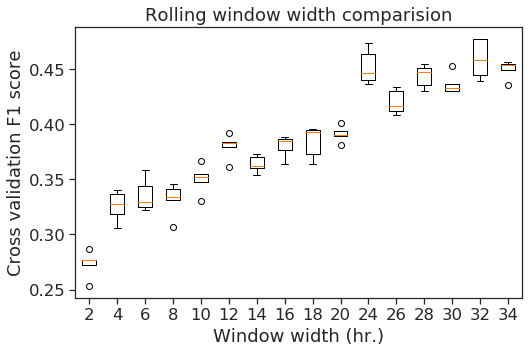

In [353]:
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(rolling_window_comparison_results['Raw scores'])
ax.set_xticklabels(rolling_window_comparison_results['Window width (hr.)'])
plt.xlabel('Window width (hr.)')
plt.ylabel('Cross validation F1 score')
plt.title('Rolling window width comparision')
#plt.xticks(rotation=45)
plt.show()

OK, very clear increase in F1 score as window width increases. Maybe this is not surprising, we already knew that a window with of 6 hrs was going to be better than none or '1 hr'. Let's call it 24 hr for now because, a) the trend seems to be leveling out and b) I can't imagine that many wildfires go undiscovered for more than a day.

## Hyperparameter optimization: class weight

One of the strange consequences of increasing the window width is an increase in the number of observations labeled fire. Now that we have the window width metaparameter nailed down, let's optimize the window with.

In [359]:
def tune_class_weight(
    class_weights, 
    x_train, 
    y_train, 
    x_test, 
    y_test
):
    model_scores_columns = [
        'Class weight',
        'Mean F1 score'
    ]
    
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for class_weight in class_weights:
        classifier = XGBClassifier(
            weight=class_weight,
            n_jobs = max_jobs, 
            random_state = rand_seed
        )

        cross_val_scores = cross_validate_classifier(
            classifier, 
            X_train, 
            y_train, 
            cv_folds, 
            scoring_func
        )
        
        model_scores = model_scores.append(pd.Series([
            class_weight,
            mean(cross_val_scores)
        ], index=model_scores.columns), ignore_index=True)
        
    return model_scores

In [354]:
# Reverse and roll data with window width
data_rolling_window = raw_data.iloc[::-1]
data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(24, on="weather_bin_time").mean()
data_rolling_window.reset_index(drop=True, inplace=True)

ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_rolling_window = ignitions.append(no_ignitions)

data_rolling_window.drop(['weather_bin_time', 'weather_bin_day'], axis=1, inplace=True)

# Take stratified sample of daily mean data and do stratified test-train split    
sampled_data = stratified_sample(data_rolling_window, sample_size)

y = sampled_data['ignition']
X = sampled_data.drop('ignition', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=test_train_split_ratio, 
    random_state=rand_seed, 
    stratify=y
)

# Scale weather variables, leave out lat, lon and date/time
columns_to_scale = X_train.columns[4:]

scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])

X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [358]:
model_scores

array([0.31132075, 0.26666667, 0.25471698, 0.3245614 , 0.2962963 ])

In [360]:
class_weights = np.logspace(-2.5, 2.5, num=5, base=10)

model_scores = tune_class_weight(
    class_weights, 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

model_scores

#plot_class_weight_tuning_results(model_scores)

,Class weight,Mean F1 score
0,0.003162,0.290712
1,0.056234,0.290712
2,1.000000,0.290712
3,17.782794,0.290712
4,316.227766,0.290712


Interesting. We can use larger class weights to drive down the false negative rate at the expense of false positives. Looking at the clearly sigmoidal precision recall curve, the optimum value looks like it's around 1. Before just using no weight, let's try this again with a narrower range.

In [ ]:
class_weights = np.logspace(-0.2, 0.2, num=25, base=10)

model_scores = tune_class_weight(
    class_weights, 
    x_train, 
    y_train, 
    x_test, 
    y_test
)

plot_class_weight_tuning_results(model_scores)

Wow, this one is actually pretty subjective... I'm calling it somewhere between one and three. Let's use 1.8 for now. This should give us ~90/85 precision-recall and put our false positive and false negative rates at 0.25 and ~0.1 respectively.

In [ ]:
known_params = {
    'random_state': rand_seed,
    'thread_count': max_jobs,
    'score_function': 'Cosine',
    'silent': True,
    'scale_pos_weight': 1.78
}

**Note:** Important to keep in mind here that we can tune our false positive/false negative rates easily with this hyperparameter.

In [ ]:
# Train model with new class weight
model_scores = train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
)

In [ ]:
model_score_history = model_score_history.append(pd.Series([
    'CatBoost with scoring function & class weight',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

## Hyperparameter tuning: learning rate and tree count

First, let's try taking one sample of the full dataset and then using RandomizedSearchCV to try and find the best values for learning rate and tree count.

In [ ]:
param_dist = {
    'learning_rate': loguniform(0.0001, 1),
    'n_estimators': range(1,200)
}

# Resample and train-test split data
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 

best_model, random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

In [ ]:
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

Surprised by how 'rough' hyperparameter space is. Let's keep the winning numbers and save the scores to our log.

In [ ]:
best_learning_rate = rand_search_results.iloc[0]['param_learning_rate']
best_n_estimators = rand_search_results.iloc[0]['param_n_estimators']

known_params = {
    'random_state': rand_seed,
    'thread_count': classifier_jobs,
    'score_function': 'Cosine',
    'silent': True,
    'scale_pos_weight': 1.78,
    'learning_rate': best_learning_rate,
    'n_estimators': best_n_estimators
}

# Resample and train-test split data
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 

# Train model with new hyperparameters
model_scores = train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
)

# Add results to score history dataframe
model_score_history = model_score_history.append(pd.Series([
    'CatBoost with n estimators and learning rate',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

Now, just for fun, let's see how our winning values for number of estimators and learning rate vary across repeated trials with different sample of the data.

In [ ]:
param_dist = {
    'learning_rate': loguniform(0.0001, 1),
    'n_estimators': range(1,200)
}

scores = []
learning_rates = []
n_estimators = []

itterations = 100

for i in range(itterations):
    # Resample and train-test split data
    sampled_data = sample_data(data_moving_avg, data_sample_size)
    targets = sampled_data['ignition']
    data = sampled_data.drop(['ignition'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 
    
    best_model, random_search = tune_hyperparameters(
        known_params,
        param_dist, 
        x_train, 
        y_train, 
        optimization_jobs, 
        search_iterations, 
        search_scoring_func
    )
    
    rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()
    winner = rand_search_results[rand_search_results['rank_test_score'] == 1]
    avg_score = winner.iloc[0]['mean_test_score']
    learning_rate = winner.iloc[0]['param_learning_rate']
    n_estimator = winner.iloc[0]['param_n_estimators']
    
    scores.append(avg_score)
    learning_rates.append(learning_rate)
    n_estimators.append(n_estimator)
    
    i += 1

In [ ]:
x = n_estimators
y = learning_rates
z = scores
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Winning estimator count and\n learning rate vs score")
plt.colorbar()
plt.show()

## Hyperparameter tuning: tree depth and L2 coefficient

In [ ]:
param_dist = {
    'depth': range(1, 21, 1),
    'l2_leaf_reg': np.linspace(0, 10, 101)
}

best_model, random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

In [ ]:
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

x = rand_search_results['param_depth']
y = rand_search_results['param_l2_leaf_reg']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Tree depth")
plt.ylabel("L2 coefficient")
plt.title("Effect of tree depth and \nL2 coefficient on score")
plt.colorbar()
plt.show()

Again, store winning parameters in dictionary and add score results to log.

In [ ]:
best_depth = rand_search_results.iloc[0]['param_depth']
best_l2_leaf_reg = rand_search_results.iloc[0]['param_l2_leaf_reg']

known_params = {
    'random_state': rand_seed,
    'thread_count': classifier_jobs,
    'score_function': 'Cosine',
    'silent': True,
    'scale_pos_weight': 1.78,
    'learning_rate': best_learning_rate,
    'n_estimators': best_n_estimators,
    'depth': best_depth,
    'l2_leaf_reg': best_l2_leaf_reg
}

# Resample and train-test split data
sampled_data = sample_data(data_moving_avg, data_sample_size)
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values) 

# Train model with new hyperparameters
model_scores = train_catboost_with_sampling(
    num_trials,
    known_params,
    data_moving_avg,
    data_sample_size,
    max_jobs
)

# Add results to score history dataframe
model_score_history = model_score_history.append(pd.Series([
    'CatBoost with depth and L2 coefficient',
    num_trials,
    model_scores.iloc[0]['Training score +/- STD'], 
    model_scores.iloc[0]['Test score +/- STD'], 
    model_scores.iloc[0]['False positive rate +/- STD'], 
    model_scores.iloc[0]['False negative rate +/- STD'],
], index=model_score_history.columns), ignore_index=True)

model_score_history

## Final model: feature importance

In [ ]:
best_model = CatBoostClassifier(**known_params)
best_model.fit(x_train, y_train)

plot_relative_feature_importance(catboost_model, data, x_test, 20)

## Final model: effect of feature count

In [ ]:
train_scores = list()
test_scores = list()

feature_names = np.array(list(data))
importances = catboost_model.feature_importances_
indices = np.argsort(importances)[::-1]

for n in range(1,(len(feature_names) + 1)):
    # grab top n feature names
    top_n_features = feature_names[indices[0:n]]

    # rebuild training and test sets with feature subset
    sampled_data = sample_data(data_moving_avg, data_sample_size)
    targets = sampled_data['ignition']
    data = sampled_data.drop(['ignition'], axis=1)
    data_subset = data[top_n_features]
    x_train_subset, x_test_subset, y_train_subset, y_test_subset  = train_test_split(data_subset, targets)

    # instantiate and train classifier
    catboost_model = CatBoostClassifier(**known_params)
    catboost_model.fit(x_train_subset, y_train_subset)

    # report score for feature subset
    training_score = average_precision_score(catboost_model.predict(x_train_subset), y_train_subset)
    test_score = average_precision_score(catboost_model.predict(x_test_subset), y_test_subset)
    
    train_scores.append(training_score)
    test_scores.append(test_score)
    
    #print('Top {} features, precision-recall score train/test: {}/{}'.format(n,np.round(training_score,2),np.round(test_score,2)))

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(1,(len(feature_names) + 1)), train_scores, s=20, c='darkblue', label='Training data')
ax.scatter(range(1,(len(feature_names) + 1)), test_scores, s=20, c='darkred', label='Test data')
plt.legend(loc='upper right')
plt.title("Model performance and feature count")
plt.xlabel("N features")
plt.ylabel("Avg. precision-recall score")
plt.show()

## Final model: robustness

In [ ]:
train_scores = list()
test_scores = list()
false_neg_rates = list()
false_pos_rates = list()

# grab top n feature names
indices = np.argsort(importances)[::-1]
top_n_features = feature_names[indices[0:7]]

for i in range(0, 1000):
    # rebuild training and test sets with feature subset
    sampled_data = sample_data(data_moving_avg, data_sample_size)
    targets = sampled_data['ignition']
    data = sampled_data.drop(['ignition'], axis=1)
    data_subset = data[top_n_features]
    x_train, x_test, y_train, y_test = train_test_split(data_subset.values, targets.values)

    # instantiate and train classifier
    catboost_model = CatBoostClassifier(**known_params)
    catboost_model.fit(x_train, y_train)

    predicted_y = catboost_model.predict(x_test)
    
    training_score = average_precision_score(catboost_model.predict(x_train), y_train)
    test_score = average_precision_score(predicted_y, y_test)

    train_scores.append(training_score)
    test_scores.append(test_score)
    
    false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_model, x_test, y_test)

    false_neg_rates.append(false_neg_rate)
    false_pos_rates.append(false_pos_rate)

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax = sns.kdeplot(train_scores, label="Training data", shade=True, color="darkblue")
ax = sns.kdeplot(test_scores, label="Test data", shade=True, color="darkred")
ax.set_title("Precision-recall score distributions")
ax.set(xlabel='Avg. precision-recall score', ylabel='Density')
plt.legend()
plt.legend(loc='upper left')

plt.show()

In [ ]:
ax = sns.kdeplot(false_neg_rates, label="False negative", shade=True, color="darkblue")
ax = sns.kdeplot(false_pos_rates, label="False positive", shade=True, color="darkred")
ax.set_title("False positive and negative rates")
ax.set(xlabel='Rate', ylabel='Density')
plt.legend()

plt.show()

In [ ]:
plt.scatter(false_neg_rates, false_pos_rates, s=5)
plt.xlabel("False negative rate")
plt.ylabel("False positive rate")
plt.title("False positive vs false negative rate")

plt.show()

## Final results

In [ ]:
model_score_comparisions

In [ ]:
model_score_history